## Generative Adversarial Network (GAN)
```
GAN consists of two neural networks: a generator and a discriminator. A normal GAN, however, does not allow class-conditional generation of data. 
Will will do use conditional GAN for that purpose.
```

In [2]:
# necessary imports
# add ../src to sys.path
import sys
sys.path.append('../src')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm, trange

import GAN

In [3]:
# load MNIST data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.MNIST(root='../../data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='../../data', train=False, download=True, transform=transform)


# data loaders
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

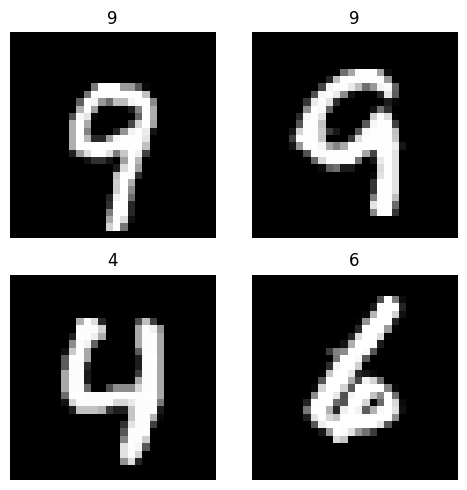

In [4]:
# visualize some data
def visualize_data(data, labels):
    fig, axs = plt.subplots(2,2, figsize=(5,5))
    axs = axs.flatten()
    for i in range(4):
        axs[i].imshow(data[i].squeeze(), cmap='gray')
        axs[i].set_title(labels[i].item())
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

# visualize some data
imgs, labels = next(iter(trainloader))
visualize_data(imgs, labels)

In [5]:
# max and min values of the data
print('max: ', torch.max(imgs))
print('min: ', torch.min(imgs))

max:  tensor(1.)
min:  tensor(-1.)


In [6]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
# image size
img_size = imgs[0].shape[1]**2 # 28*28 = 784

# noise dim
noise_dim = 100

In [9]:
# create generator and discriminator models
generator = GAN.Generator(noise_dim, img_size).to(device)
discriminator = GAN.Discriminator(img_size).to(device)

In [10]:
# test generator
noise = torch.randn(32, noise_dim).to(device)
fake_imgs = generator(noise)
print(fake_imgs.shape)

# test discriminator
preds = discriminator(fake_imgs)
print(preds.shape)

torch.Size([32, 784])
torch.Size([32, 1])


In [11]:
# optimizers
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

# loss function
criterion = nn.BCELoss()

In [14]:
# training loop
epochs = 500
for epoch in trange(epochs):
    for i, (imgs, _) in enumerate(trainloader):
        
        # real images
        real_imgs = imgs.view(-1, img_size).to(device)
        batch_size = real_imgs.shape[0]
        real_labels = torch.ones(batch_size, 1).to(device)

        # fake images
        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_imgs = generator(noise)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # train discriminator
        optimizer_D.zero_grad()
        real_preds = discriminator(real_imgs)
        fake_preds = discriminator(fake_imgs)
        real_loss = criterion(real_preds, real_labels)
        fake_loss = criterion(fake_preds, fake_labels)
        loss_D = real_loss + fake_loss
        loss_D.backward()
        optimizer_D.step()

        # train generator
        optimizer_G.zero_grad()
        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_imgs = generator(noise)
        fake_preds = discriminator(fake_imgs)
        loss_G = criterion(fake_preds, real_labels)
        loss_G.backward()
        optimizer_G.step()

    # print losses
    if epoch % 50 == 0:
        print('epoch: ', epoch, 'loss_D: ', loss_D.item(), 'loss_G: ', loss_G.item())

  0%|          | 1/500 [00:06<56:24,  6.78s/it]

epoch:  0 loss_D:  1.1428446769714355 loss_G:  0.979158878326416


 10%|█         | 51/500 [05:44<51:22,  6.86s/it]

epoch:  50 loss_D:  1.1726210117340088 loss_G:  1.2037057876586914


 20%|██        | 101/500 [11:20<45:14,  6.80s/it]

epoch:  100 loss_D:  1.0457937717437744 loss_G:  1.2390246391296387


 30%|███       | 151/500 [17:02<39:18,  6.76s/it]

epoch:  150 loss_D:  0.9058335423469543 loss_G:  1.5066449642181396


 40%|████      | 201/500 [22:33<32:27,  6.51s/it]

epoch:  200 loss_D:  1.0851385593414307 loss_G:  0.9047867059707642


 50%|█████     | 251/500 [28:10<27:54,  6.72s/it]

epoch:  250 loss_D:  1.003739833831787 loss_G:  1.4300706386566162


 60%|██████    | 301/500 [33:48<22:25,  6.76s/it]

epoch:  300 loss_D:  0.9848849773406982 loss_G:  1.2346057891845703


 70%|███████   | 351/500 [39:23<16:42,  6.73s/it]

epoch:  350 loss_D:  0.8986469507217407 loss_G:  1.3470230102539062


 80%|████████  | 401/500 [44:59<10:58,  6.65s/it]

epoch:  400 loss_D:  0.7752115726470947 loss_G:  1.5048189163208008


 90%|█████████ | 451/500 [50:35<05:32,  6.78s/it]

epoch:  450 loss_D:  0.8868981599807739 loss_G:  2.0320889949798584


100%|██████████| 500/500 [56:02<00:00,  6.73s/it]


In [15]:
# generate some data
noise = torch.randn(32, noise_dim).to(device)
fake_imgs = generator(noise).detach().cpu().numpy()

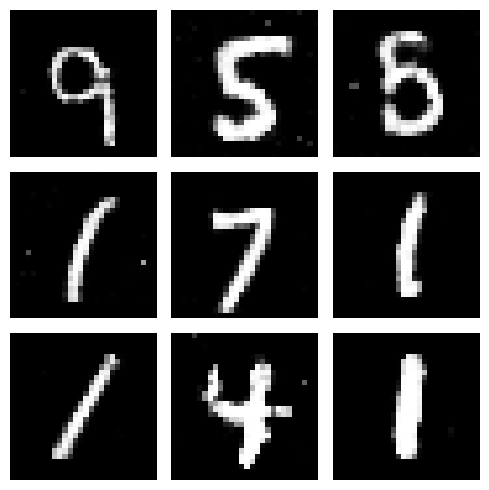

In [20]:
# visualize some generated data, 3x3 grid
fig, axs = plt.subplots(3,3, figsize=(5,5))
axs = axs.flatten()
for i in range(9):
    axs[i].imshow(fake_imgs[i].reshape(28,28), cmap='gray')
    axs[i].axis('off')
plt.tight_layout()
plt.show()


```
Nice!
```